## Prerequisites
1. Create a kafka service named my-kafka on default-tenant namespace - you can use this confluent document [link](https://confluence.iguazeng.com/display/FC/Kafka%3A+deployment+in+2+minutes) 
2. creating a kafka input, output,error topics and broker address equal to the keys below, each value store with his unique keys as a project params:
    * input_topic 
    * output_topic 
    * error_topic 
    * broker 
    * All the params assign to the project YAML
3. Create a Redis service  - Run those commands:
    * `helm repo add bitnami https://charts.bitnami.com/bitnami`
    * `helm repo update`
    * `helm install -n default-tenant  redis-test  --set auth.enabled=false bitnami/redis`
4. Creating a redis service , saved as a project params with redis_path key - 
    * redis_path - redis://redis-test-master.default-tenant.svc.cluster.local:6379
4. clone this repo to your jupyter service - make sure you are running this notebook from the repo directory


In [1]:
import mlrun
from mlrun import feature_store as fs

In [2]:
from mlrun.datastore.targets import RedisNoSqlTarget, ParquetTarget
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [3]:
import pandas as pd
import kafka

In [4]:
import os
import requests

In [5]:
project_name = 'kafka-fs-test'

In [6]:
project = mlrun.get_or_create_project(project_name,'./kafka_redis_fs/',user_project=True)

> 2022-12-12 15:48:41,238 [info] loaded project kafka-fs-test from MLRun DB


#### Creates Kafka Topics and Consumers

In [12]:
topic_in = project.get_param('input_topic')
topic_out = project.get_param('output_topic')
topic_err = project.get_param('error_topic')
brokers = project.get_param('broker')

In [13]:
kafka_admin_client = kafka.KafkaAdminClient(bootstrap_servers=brokers)

In [14]:
kafka_consumer_in = kafka.KafkaConsumer(topic_in,bootstrap_servers=brokers,auto_offset_reset="earliest",max_poll_records=3)

In [15]:
kafka_consumer_out = kafka.KafkaConsumer(topic_out,bootstrap_servers=brokers,auto_offset_reset="earliest",)

In [16]:
kafka_consumer_err = kafka.KafkaConsumer(topic_err,bootstrap_servers=brokers,auto_offset_reset="earliest",)

#### Creating FS

In [17]:
redis_path = project.get_param('redis_path')

In [18]:
source_path = './data/data_ingest.csv'

In [19]:
transactions_data = pd.read_csv(source_path)

In [20]:
transactions_data = transactions_data.sample(100)

In [21]:
#Sort value by time that the last time record will be the last row in the table
transactions_data = transactions_data.sort_values(['timestamp'])

In [22]:
# mlrun: start-code

In [23]:

def len_device(event):
    event['len_device']=len(event['device'])
    return event

def check_len_device(event):
    if event['len_device'] > 5:
        event['check_len_device'] = 'Bigger Then 5'
        return event 
    else:
        event['check_len_device'] = 'Smaller Or Equal to 5'
        return event

In [24]:
# mlrun: end-code

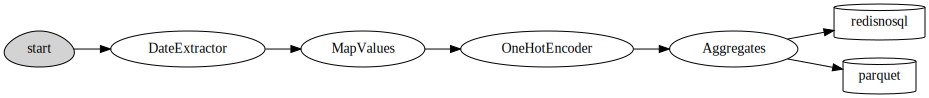

In [25]:
# Define and add value mapping
transaction_set = fs.FeatureSet("transactions", 
                                 entities=[fs.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping)).respond()


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
targets = [RedisNoSqlTarget(path=redis_path),ParquetTarget()]
transaction_set.set_targets(
    targets=targets,
    with_defaults=False,
)
# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

In [26]:
ingest_df=fs.ingest(transaction_set, transactions_data,overwrite=True,infer_options=fs.InferOptions.default())

In [27]:
ingest_df

,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_avg_2h,...,category_es_tech,category_es_otherservices,category_es_sportsandtoys,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1182534509,1.0,1.0,1.0,5.71,5.71,5.71,5.71,5.71,5.71,5.71,...,0,0,0,5.71,0,2022-12-04 10:08:29.017161,M1823072687,271f5a4f3a2a4b32a26726899e35b4db,10,6
C1063753312,1.0,1.0,1.0,17.83,17.83,17.83,17.83,17.83,17.83,17.83,...,0,0,0,17.83,0,2022-12-04 10:25:05.777839,M1823072687,ad8db8224d6e48a59106d5eacd1604fb,10,6
C1153943594,1.0,1.0,1.0,15.65,15.65,15.65,15.65,15.65,15.65,15.65,...,0,0,0,15.65,0,2022-12-04 10:29:10.617852,M348934600,0a752bd58a244fbc882167fd231d8981,10,6
C1035222482,1.0,1.0,1.0,63.65,63.65,63.65,63.65,63.65,63.65,63.65,...,0,0,0,63.65,0,2022-12-04 11:10:55.254335,M348934600,cf73c2657b944e72be2d8f9f7eb6004e,11,6
C1091680547,1.0,1.0,1.0,22.90,22.90,22.90,22.90,22.90,22.90,22.90,...,0,0,0,22.90,0,2022-12-04 11:52:53.557250,M348934600,00718eae528846189e1772d5024531d6,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1063753312,1.0,1.0,1.0,7.74,7.74,7.74,7.74,7.74,7.74,7.74,...,0,0,0,7.74,0,2022-12-06 06:26:30.729232,M1823072687,ad8db8224d6e48a59106d5eacd1604fb,6,1
C1102156492,1.0,1.0,1.0,13.09,13.09,13.09,13.09,13.09,13.09,13.09,...,0,0,0,13.09,0,2022-12-06 08:03:45.523212,M348934600,881c36b3b93c40dcbfe23b3f1009373a,8,1
C1005126300,1.0,1.0,1.0,94.25,94.25,94.25,94.25,94.25,94.25,94.25,...,0,0,0,94.25,0,2022-12-06 08:32:37.531782,M85975013,070317a51ebe43a7b21ffadf286f3844,8,1


In [28]:
#check that all rows from the dataframe ingested
ingest_df.shape[0]==transactions_data.shape[0]

True

#### Creating a deploy_ingestion_service function

In [29]:
steps = mlrun.code_to_function('steps',kind='serving',image='mlrun/mlrun')

In [30]:
from mlrun.datastore import KafkaSource
source = KafkaSource(brokers=brokers,topics=topic_in)

ingest_service = fs.deploy_ingestion_service(transaction_set,source=source,run_config=fs.RunConfig(steps))

> 2022-12-12 15:48:58,766 [info] Starting remote function deploy
2022-12-12 15:48:58  (info) Deploying function
2022-12-12 15:48:58  (info) Building
2022-12-12 15:48:59  (info) Staging files and preparing base images
2022-12-12 15:48:59  (info) Building processor image
2022-12-12 15:50:54  (info) Build complete
2022-12-12 15:51:54  (info) Function deploy complete
> 2022-12-12 15:51:55,541 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-kafka-fs-test-shapira-steps.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['kafka-fs-test-shapira-steps-kafka-fs-test-shapira.default-tenant.app.jmglmvqnganv.iguazio-cd1.com/']}


#### Test ingest Data with a simple requests

In [31]:
import datetime
import time
import random
df_json=pd.read_json('./json_files/json_49991.json',orient='index',typ='series')
ingest_dict = df_json.to_dict()
ingest_dict
res=steps.invoke('/',ingest_dict)
print(res)

> 2022-12-12 15:51:55,673 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-kafka-fs-test-shapira-steps.default-tenant.svc.cluster.local:8080/'}
{'id': 'a751f4f3-5eeb-46b6-a1b2-f16243e82c96'}


#### Send requests to the Kafka trigger

In [32]:
producer  = kafka.KafkaProducer(bootstrap_servers=[brokers])

In [33]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./json_files/') if isfile(join('./json_files/', f))]

In [34]:
onlyfiles.remove('json_49991.json')

In [35]:
import datetime
s = datetime.datetime.now()
import json
for file in onlyfiles:
    df_json=pd.read_json(f'./json_files/{file}',typ='series')
    ingest_dict = df_json.to_dict()
    ms=json.dumps(ingest_dict).encode('utf-8')
    producer.send(topic=topic_in,value=ms)

In [36]:
counter = 0
for i in onlyfiles:
    record = next(kafka_consumer_in)
    counter += 1
    print(record)

ConsumerRecord(topic='input_topic_fs_1', partition=0, offset=0, timestamp=1670342070330, timestamp_type=0, key=None, value=b'{"step": 71, "age": "2", "gender": "F", "zipcodeOri": 28007, "zipMerchant": 28007, "category": "es_transportation", "amount": 15.86, "fraud": 0, "timestamp": "2022-12-05 19:02:04.921858", "source": "C1189752912", "target": "M348934600", "device": "794f7a37106e4f2e89ff3ac26977fa04"}', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=282, serialized_header_size=-1)
ConsumerRecord(topic='input_topic_fs_1', partition=0, offset=1, timestamp=1670342070337, timestamp_type=0, key=None, value=b'{"step": 36, "age": "2", "gender": "F", "zipcodeOri": 28007, "zipMerchant": 28007, "category": "es_transportation", "amount": 2.74, "fraud": 0, "timestamp": "2022-12-05 07:31:42.659364", "source": "C1189752912", "target": "M348934600", "device": "7f398b2024bf419f89833c93fe659c48"}', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=281

In [37]:
#Check if all the inputs got into kafka
counter == len(onlyfiles)

True

#### Creating feature vectore

In [38]:
features = [
    "transactions.*",
]

vector = fs.FeatureVector("transactions-vector",features=features,description="this is my vector")
resp = fs.get_offline_features(vector,with_indexes=True)
#Preview the dataset
resp.to_dataframe().tail(5)

,timestamp,amount_avg_2h,amount_avg_12h,amount_avg_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_count_2h,amount_count_12h,amount_count_24h,...,category_es_hyper,category_es_tech,category_es_otherservices,category_es_sportsandtoys,amount,fraud,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1063753312,2022-12-06 06:26:30.729232,7.74,7.74,7.74,7.74,7.74,7.74,1.0,1.0,1.0,...,0,0,0,0,7.74,0,M1823072687,ad8db8224d6e48a59106d5eacd1604fb,6,1
C1102156492,2022-12-06 08:03:45.523212,13.09,13.09,13.09,13.09,13.09,13.09,1.0,1.0,1.0,...,0,0,0,0,13.09,0,M348934600,881c36b3b93c40dcbfe23b3f1009373a,8,1
C1005126300,2022-12-06 08:32:37.531782,94.25,94.25,94.25,94.25,94.25,94.25,1.0,1.0,1.0,...,0,0,0,0,94.25,0,M85975013,070317a51ebe43a7b21ffadf286f3844,8,1
C1000148617,2022-12-06 08:51:19.678095,60.98,60.98,60.98,60.98,60.98,60.98,1.0,1.0,1.0,...,0,0,0,0,60.98,0,M1823072687,741ccdad2743422c98939329976a9c06,8,1
C1037622786,2022-12-06 09:00:37.381203,61.02,61.02,61.02,61.02,61.02,61.02,1.0,1.0,1.0,...,1,0,0,0,61.02,0,M855959430,0872d3d41bd44129ba0d49a3120aae43,9,1


In [ ]:
svc = fs.get_online_feature_service(vector.uri)
resp = svc.get([{"source": 'C1145304322'}])
resp

In [ ]:
transaction_set.purge_targets()